# Exercise: Feature selection - system state prediction

In this exercise, we will use logistic regression as a classifier to predict system imbalance state using features such as past imbalance volumes, past imbalance prices, day-ahead prices, renewable dispatch, and others. Predicting imbalance state has applications in short-term trading, where the arbitrage between day-ahead/intraday and imbalance price is strongly correlated with the system imbalance state. We construct three classes; short, long, neutral, signifying the state of system imbalance. Short and long refers to system state in case of deficit and excess of generation, respectively, and neutral refers to low imbalance. We introduce the class *neutral* since it is hard to predict the imbalance state in case of low imbalance. Logistic regression models the log-probability of an event as a linear combination of features, using the logistic function reading as
$$
p(x; w,b) = \frac{1}{1+e^{w^\top x + b}},
$$
where $w$ and $b$ are weights and bias corresponding to the linear combination, and we define p to represent the probability of the system being long. Note that the logistic function returns values between 0 and 1.

To build a classifier from logistic regressor, we define a *threshold* parameter $\theta$, such that an instance is classified as long if $p/(1-p)>\theta$, and short if $p/(1-p)<1/\theta$, else neutral.

## 1 - Time series prediction using past imbalance volumes
In this section, we will use only the past imbalance volumes as features to predict the next imbalance state. For instance, to predict the imbalance state at time t, we can use the last n imbalance volumes for slots t-n, ..., t-1 as features and fit a logistic regressor.

Now, we describe the metrics used to evaluate our classifier's performance. First, we have *accuracy* which denotes the number of samples classified correctly as either long of short, excluding those classified as neutral.

Next, we have the proportion of dropped instances, meaning the proportion of instances classified as neutral.

Next, we have the logloss (cross entropy) evaluated on validation set which is the same objective used for training the logistic regressor.

$$
- \sum_i y_i \log(p(x_i; w,b)) + (1-y_i)\log(1-p(x_i;w,b))
$$
### Tasks

- First, let us prepare the data from the given dataset. The dataset provides us with volumes for T slots. Prepare features and targets for a look back window of size n?
- Split the dataset into training and validation sets.
- Train a linear regressor and evaluate it on the validation set using accuracy and proportion of dropped instances.
- Plot performance as a function of window size and find a good window size.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss, log_loss
import pandas as pd
import numpy as np

def get_data(N, dataset):
    # -------------------------------------------------------------------------
    # Load the dataset and preprocess it to create a supervised learning problem.
    df = pd.read_csv(dataset)
    T = len(df)
    data_dict = {f"Imbalance t-{N+1-n}": df["Imbalance"].values[n-1:T-N+n-1] for n in range(1, N+1)}
    data_dict["Direction"] = df["Direction"].values[N:T]
    data_dict["Slot Id"] = df["Slot Id"].values[N:T]
    data = pd.DataFrame(columns=['Slot Id'] + [f"Imbalance t-{N+1-n}" for n in range(1, N+1)] + ["Direction"], data=data_dict)
    return data

def train_log_regressor(data: pd.DataFrame, drop = [], reg = 1):
    """
    Trains a logistic regressor to predict 'Imbalance price' using all the other features in the dataset, dropping the features in the 'drop' list.
    """
    # -------------------------------------------------------------------------
    # Split the dataset into training and validation sets. Scikit-learn offers a train_test_split function, check documentation.
    train_df, val_df = train_test_split(data.drop(columns=drop), test_size=0.2, random_state=42, shuffle=False)

    # -------------------------------------------------------------------------
    # Train a linear regression model on the training set and evaluate it on the test set.
    model = LogisticRegression(penalty='l1', solver='liblinear', C=1/reg)
    feature_df = train_df.drop(columns=["Slot Id", "Direction"])
    # print(f"Training on features: {feature_df.columns}")
    model.fit(feature_df, train_df["Direction"])
    
    return model, val_df

def evaluate(df, model, threshold = 2):
    # -------------------------------------------------------------------------
    # Evaluate the model
    prob_preds = model.predict_proba(df.drop(columns=["Slot Id", "Direction"]))
    logloss = log_loss(df["Direction"], prob_preds)

    conf_surplus = prob_preds[:, 1]/prob_preds[:, 0]
    preds = np.where(conf_surplus>=threshold, 1, 0)
    preds = np.where(conf_surplus<1/threshold, -1, preds)
    
    neutral = 0
    true = 0
    false = 0
    for i in range(len(df["Direction"])):
        if preds[i] == 0:
            neutral += 1
        elif preds[i] == df["Direction"].iloc[i]:
            true += 1
        else:
            false += 1
    
    accuracy = true/(true+false)
    dropped_instances = neutral/(true+false+neutral)

    return {'logloss': logloss, 'accuracy': accuracy, 'dropped_instances': dropped_instances, 'coef': model.coef_, 'intercept': model.intercept_}

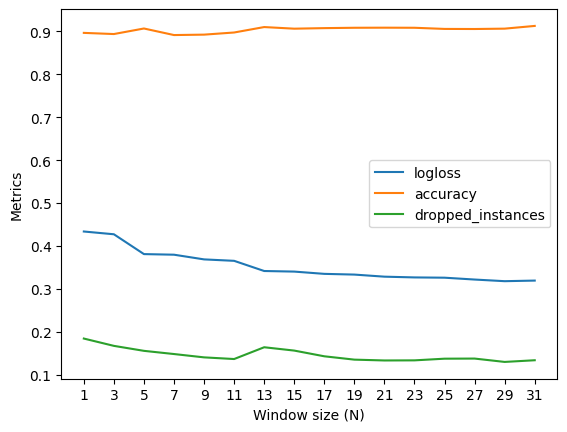

Metrics for model N=19:
Logloss: 0.33376047993237357
Accuracy: 0.9078651685393259
Dropped_instances: 0.13592233009708737


In [3]:
import numpy as np
dataset = "imbalance_features_2025_06_train.csv"
# Analyze the effect of the window size N on the model performance by using the functions above and plotting performance metrics as a function of N.
metrics = {'logloss': [], 'accuracy': [], 'dropped_instances': []}
set_N = np.linspace(1, 31, 16, dtype=int)
for N in set_N:
    data = get_data(N, dataset)
    def print(*args): # suppressing print function for a while
        pass
    model, val_df = train_log_regressor(data)
    metric = evaluate(val_df, model)
    [metrics[key].append(metric[key]) for key in metrics]

del print # reactivate print
[plt.plot(np.array(metrics[key]), label=key) for key in metrics]
plt.xlabel("Window size (N)")
plt.ylabel("Metrics")
plt.xticks(range(len(metrics['logloss'])), set_N)
plt.legend()
# plt.ylim(0.2, 0.3)
plt.show()

print("Metrics for model N=19:")
print(f"Logloss: {metrics['logloss'][9]}")
print(f"Accuracy: {metrics['accuracy'][9]}")
print(f"Dropped_instances: {metrics['dropped_instances'][9]}")

# 2 - Time series prediction with external features
Since, the imbalance volume is affected by other market quantities, we include external features to improve our model. Note that, only features that are available a-priori to the delivery time are valid features, since prediction model needs to be run before delivery time.

### Tasks
- Now, use other features in the dataset as well. Try to find a nice set of features that are useful or use regularization for feature selection.
- How does the performance vary with the threshold parameter $\theta$?

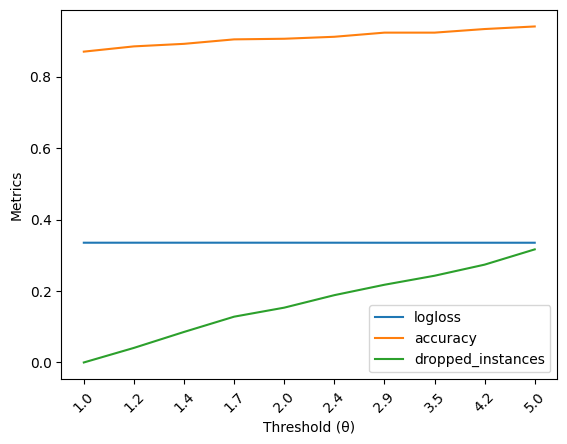

In [8]:
def get_data_ex_features(N, dataset):
    df = pd.read_csv(dataset)
    data = get_data(N, dataset)
    data = data.merge(df.drop(columns=["Time slot", "Direction", "Imbalance", "Imbalance price"]), on="Slot Id") # Only a-priori available quantities can be used as features
    return data

N = 19
dataset = "imbalance_features_2025_06_train.csv"
data = get_data_ex_features(N, dataset)

metrics = {'logloss': [], 'accuracy': [], 'dropped_instances': []}
set_threshold = np.logspace(0, 0.7, 10)
for i, thr in enumerate(set_threshold):
    # Here we use all features, input features in the drop list if you want to drop some
    model, val_df = train_log_regressor(data, drop=[])
    metric = evaluate(val_df, model, threshold=thr)
    [metrics[key].append(metric[key]) for key in metrics]

[plt.plot(np.array(metrics[key]), label=key) for key in metrics]
plt.xlabel("Threshold (θ)")
plt.ylabel("Metrics")
plt.xticks(range(len(metrics['logloss'])), np.round(set_threshold, 1), rotation=45)
plt.legend()
# plt.ylim(0.2, 0.3)
plt.show()

## 3 - Time series prediction with polynomial features
Recall how polynomial regression was implemented by using polynomial features in linear regression in the ridge and lasso exercise and your assignment. Here, we want to do the same for our problem, by using polynomial features in logistic regression.

### Tasks
- How is the performance with polynomial features?
- See if regularization helps, how can you increase regularization?
- How does the performance vary with the threshold parameter $\theta$?

In [5]:
from sklearn.preprocessing import PolynomialFeatures

def train_poly(data, drop = [], reg = 1):

    # -------------------------------------------------------------------------
    # Transform the features into polynomial features and split the dataset into training and testing sets. Scikit-learn offers a train_test_split function, check documentation.
    poly = PolynomialFeatures(degree=2, include_bias=True)
    features = poly.fit_transform(data.drop(columns=["Slot Id", "Direction"]+drop))
    targets = data["Direction"].values
    train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.2, random_state=42, shuffle=False)

    # -------------------------------------------------------------------------
    # Train a linear regression model on the training set and evaluate it on the test set.
    model = LogisticRegression(C=1/reg, max_iter=1000)
    model.fit(train_features, train_targets)

    return model, val_targets, val_features

def evaluate_poly(features, targets, model, threshold=2):
    # -------------------------------------------------------------------------
    # Evaluate the model
    prob_preds = model.predict_proba(features)
    logloss = log_loss(targets, prob_preds)

    conf_surplus = prob_preds[:, 1]/prob_preds[:, 0]
    preds = np.where(conf_surplus>=threshold, 1, 0)
    preds = np.where(conf_surplus<1/threshold, -1, preds)
    
    neutral = 0
    true = 0
    false = 0
    for i in range(len(targets)):
        if preds[i] == 0:
            neutral += 1
        elif preds[i] == targets[i]:
            true += 1
        else:
            false += 1
    
    accuracy = true/(true+false)
    dropped_instances = neutral/(true+false+neutral)

    return {'logloss': logloss, 'accuracy': accuracy, 'dropped_instances': dropped_instances, 'coef': model.coef_, 'intercept': model.intercept_}
    

C:\Users\s200583\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\s200583\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increa

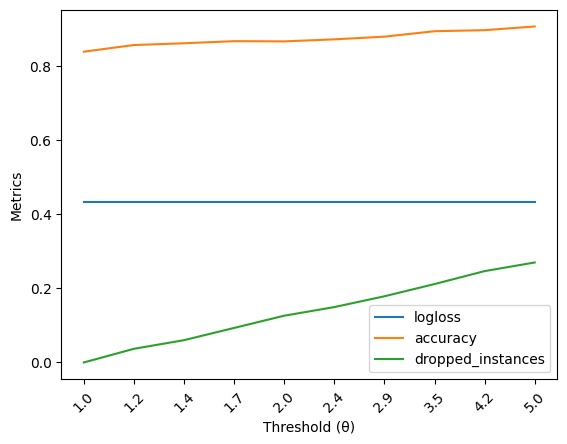

In [6]:
N = 19
dataset = "imbalance_features_2025_06_train.csv"
data = get_data_ex_features(N, dataset)

metrics = {'logloss': [], 'accuracy': [], 'dropped_instances': []}
set_threshold = np.logspace(0, 0.7, 10)
for i, thr in enumerate(set_threshold):
    model, targets, features = train_poly(data, drop=[])
    metric = evaluate_poly(features, targets, model, threshold=thr)
    [metrics[key].append(metric[key]) for key in metrics]

[plt.plot(np.array(metrics[key]), label=key) for key in metrics]
plt.xlabel("Threshold (θ)")
plt.ylabel("Metrics")
plt.xticks(range(len(metrics['logloss'])), np.round(set_threshold, 1), rotation=45)
plt.legend()
# plt.ylim(0.2, 0.3)
plt.show()


Now, evaluate your final model's peformance on the test set.

In [7]:
N = 19
dataset_train = "imbalance_features_2025_06_train.csv"
dataset_test = "imbalance_features_2025_06_test.csv"
data_train = get_data_ex_features(N, dataset_train)
data_test = get_data_ex_features(N, dataset_test)

# In this solution we choose the polynomial model with all features and threshold 2, this is not necessarily the best choice, just an example

model, _, _ = train_poly(data_train, drop=[])

poly = PolynomialFeatures(degree=2, include_bias=True)
test_features = poly.fit_transform(data_test.drop(columns=["Slot Id", "Direction"]))
test_targets = data_test["Direction"].values

# Evaluate on test set
test_metric = evaluate_poly(test_features, test_targets, model, threshold=2)

print("Final model performance on test set:")
print(f"Logloss: {test_metric['logloss']:.4f}")
print(f"Accuracy: {test_metric['accuracy']:.4f}")
print(f"Dropped instances: {test_metric['dropped_instances']:.4f}")

Final model performance on test set:
Logloss: 0.4269
Accuracy: 0.8475
Dropped instances: 0.1710


C:\Users\s200583\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
